

#0 . Modelo de LGD usando AutoML



O objetivo desse estudo é comparar a metodologia tradicional de modelagem de LGD com a metodologia de Auto Machine Learning.

Nesta seção são descritos os passos relacionados à preparação dos dados e análises quantitativas. O objetivo é viabilizar a replicabilidade do estudo por outros pesquisadores, que terão  a oportunidade de desafiar a metodologia utilizada, ou expandir a aplicação em outras bases ou parâmetros de risco de crédito.

Neste estudo são avaliados os empréstimos realizados pelo Lending Club, uma empresa com grande relevância no mercado de financiamento Peer-to-Peer dos Estados Unidos.

Os dados foram obtivos da plataforma Kaggle e podem ser acessados neste [link](https://www.kaggle.com/code/ztrimus/loan-repayment-prediction/data?select=Loan_status_2007-2020Q3.gzip). No link também é disponibilizado o dicionário de dados da base.

As bibliotecas, tanto instalação quanto importação, são instaladas no início do código para garantir a versão e replicabilidade dos resultados **(após a instalação delas no COLAB é necessário reiniciar o ambiente)**. Todo o desenvolvimento foi realizado com a utilização do **Python** na ferramenta **Colaboratory** do Google. Depois é feita a conexão com o Google Drive, para acesso à base de dados. Esses passos são realizados nesta etapa (módulo 0).

O processamento do módulo 1 é pré-requisito para os demais e eles são processados de forma independente. Ou seja, após o módulo 1 o módulo 3 pode ser processado diretamente.

O Auto-Sklearn tem um tratamento separado para a importação, pois há uma inconsistência entre a versão atual do Python e a mais recente do Auto-Sklearn. Essa correção seguiu as orientações do seguinte [link](https://github.com/automl/auto-sklearn/issues/1684).

Após esse processo, reiniciar o ambiente.

In [ ]:
# Tratamentos iniciais para o uso do auto-sklearn
!pip install Cython==0.29.36
!pip uninstall scipy -y
!pip install scipy==1.9
!pip uninstall pyparsing -y
!pip install pyparsing==2.4
!pip uninstall scikit_learn -y

# Bibliotecas excluídas para não afetar o auto-sklearn
!pip uninstall imbalanced-learn -y
!pip uninstall mlxtend -y
!pip uninstall yellowbrick -y

# Bibliotecas utilizadas no desenvolvimento
!pip install google.colab==1.0.0
!pip install ipython==7.34.0
!pip install matplotlib==3.7.1
!pip install pandas==1.5.3
!pip install PipelineProfiler==0.1.18
!pip install pydotplus==2.0.2
!pip install seaborn==0.12.2
!pip install shap==0.41.0
!pip install statsmodels==0.14.0
!pip install xlsxwriter==3.1.9
!pip install numpy==1.23.5

Notar que nas etapas abaixo o ambiente deve ser reiniciado. Mas reiniciar também antes de iniciar as etapas abaixo.

In [ ]:
#Processar a parte abaixo e reiniciar o ambiente
!pip install scikit-learn==0.24.2 --no-build-isolation

In [ ]:
#Processar a parte abaixo e reiniciar o ambiente
!pip install auto-sklearn==0.15.0

## 0.1 Após reiniciar o ambiente de execução

Na sequencia, conectar a pasta do google drive. Código abaixo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1 . Importando e tratando os dados

### Nesta etapa são descritos os procedimentos iniciais para definição da amostra de desenvolvimento e teste. Também são construídas algumas funções auxiliares.


## 1.1 Importando as informações relevantes

Devido ao tamanho da base, ela é importada por partes. Nessa etapa foram mantidos apenas os registros elegíveis à apuração do LGD, pelo critéio `loan_status == 'Charged Off' ou 'Does not meet the credit policy. Status:Charged Off'`.

O total de colunas/variáveis da base original é 141 e após a exclusão dos registros que não foram classificados como default, a base é reduzida de **2.925.494** para **363.309** registros.

Nesta etapa também foram excluídas 31 observações devido ao principal ter sido 100% recuperado antes do default. Nessa situação o denominador do LGD=0. Isso reduz a base ara **363.278** registros.


In [2]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")              # ignora avisos desnecessários no código, deixando  o output mais limpo
pd.set_option('display.max_columns', None)     # ajuste da visualização de tabela para todas as colunas
pd.set_option('display.max_rows', None)        # ajuste da visualização de tabela para todas as linhas
pd.set_option('mode.chained_assignment', None) # evita o aviso de processamento do Pandas

# Mapeia a localização dos dados a partir do google drive.
os.chdir('/content/drive/My Drive/1 - LGD/0 - Dados e Códigos/0 - Bases')

# Importa os dados e faz os trata da variável resposta, gerando a base LGD
df0 = pd.read_csv('Loan_status_2007-2020Q3.zip', compression='zip', low_memory=False, index_col=0, nrows = 1500000)
df1 = df0[df0['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])] #(133481, 141)
df2 = pd.read_csv('Loan_status_2007-2020Q3.zip', compression='zip', low_memory=False, index_col=0, skiprows=[i for i in range(1,1500000)])
df3 = df2[df2['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])] #(229828, 141)
df4 = df1.append(df3, ignore_index=True) #(363309, 141)

# Exclusão dos 31 casos onde não é possível apurar o LGD
df = df4[(df4['loan_amnt']-df4['total_rec_prncp'])>0] # 31 registros

print('df4 (linhas, colunas) =',df4.shape)
print('df (linhas, colunas) =',df.shape)

del df0, df1, df2, df3, df4

df4 (linhas, colunas) = (363309, 141)
df (linhas, colunas) = (363278, 141)


Nesta etapa é construída a variável LGD e avaliada a sua distribuição ao longo dos anos no que se refere à forma, média `lgd` e percentual que apresenta 100% (ou seja, as situações onde nada foi recuperado `ldg_d`). A variável foi censurada em -0,3 porém  apenas 17 operações foram impactadas e mantidas na base. Esse tratamento é relevante para a regressão e dada a baixa representatividade a opção foi  manter da mesma forma em todas as análises e testes seguintes.




In [3]:
# Transforma a informação de data de concessão do crédito e deleta a variável original, bem como o status do empréstimo
df['year'] = pd.DatetimeIndex(df['issue_d']).year

# Construção do LGD
df['lgd'] = 1-((df['recoveries']-df['collection_recovery_fee'])/(df['loan_amnt']-df['total_rec_prncp']))
df['lgd'] = np.where(df['lgd'] < -0.3, -0.3, df['lgd']) # 17 censurados
df['lgd_d'] = np.where(df['lgd']==1, 1, 0)


Pelo Gráfico abaixo observamos que o LGD apresenta estabilidade apenas no período entre 2014 e 2017. Antes de 2014 a carteira era bem pouco representativa e após 2017 o LGD piora muito, provavelmente devido ao menor período para acompanhamento da recuperação.

Dessa forma foi considerado apenas o período de **2014** a **2017** para o estudo, reduzindo a amostra de **363.278** para **266.515** empréstimos.

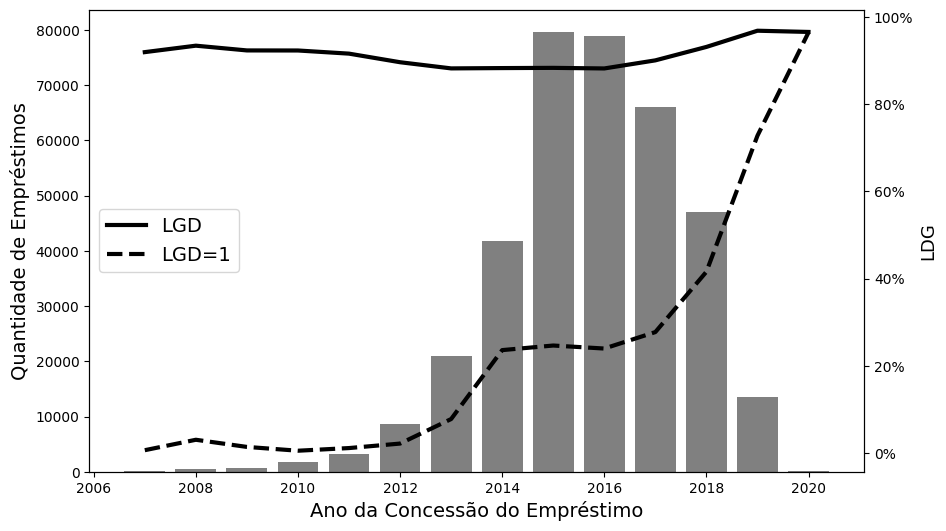

In [4]:
avaliacao = df.groupby(['year'], as_index=False).agg({'id':'count', 'lgd': np.mean, 'lgd_d': np.mean})
plt.style.use('default')
fig, ax = plt.subplots(figsize = (10,6))
#plt.title('Gráfico 1 - Qtde de Empréstimos e LGD Médio', fontsize = 16)
plt.xlabel('Ano da Concessão do Empréstimo', fontsize = 14)
ax.bar(avaliacao['year'], avaliacao['id'], color="grey")
ax2 = ax.twinx()
ax2.plot(avaliacao['year'], avaliacao['lgd'], color="black", linestyle='-', linewidth=3, label = 'LGD')
ax2.plot(avaliacao['year'], avaliacao['lgd_d'], color="black", linestyle='--', linewidth=3, label = 'LGD=1')
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
ax.set_ylabel('Quantidade de Empréstimos', color = 'black', fontsize = 14)
ax2.set_ylabel('LDG', color = 'black', fontsize = 13)
plt.legend(fontsize = 14, loc=6)
plt.show()

Os custos de recuperação referente ao comissionamento da Lending Club, em média, representam 17,5% da recuperação observada e tem comportamento estável ao longo dos anos selecionados para o estudo (2014 a 2017). Assim, para trabalhar com o valor mais adequado do parâmetro, neste estudo o LGD considera esse custo, subtraindo ele da recuperação observada.

In [5]:
total = df.groupby(['year'], as_index=False).agg({'id':'count', 'collection_recovery_fee': np.sum, 'recoveries': np.sum, 'lgd': np.mean})
total['prop'] =  total['collection_recovery_fee']/total['recoveries']
total = total.drop(columns=['collection_recovery_fee','recoveries'])
total

,year,id,lgd,prop
0,2007,158,0.919062,0.213730
1,2008,496,0.933848,0.234826
2,2009,723,0.922961,0.243431
3,2010,1757,0.922814,0.170075
4,2011,3297,0.915597,0.097061
5,2012,8644,0.895902,0.088827
6,2013,21027,0.881759,0.126838
7,2014,41744,0.882486,0.165219
8,2015,79690,0.882989,0.178740
9,2016,78998,0.881632,0.176490



Foram mantidas as novas variáveis `year` e `lgd`, levando a base para 143 variáveis. A variável auxiliar `lgd_d` foi excluída pois não é feita nenhuma avaliação de resposta binária neste estudo.

In [6]:
del avaliacao
df = df.drop(columns=['lgd_d'])
df = df[df.year.isin([2014, 2015, 2016, 2017])]
print('df (linhas, colunas) =', df.shape) #df.shape (266515, 143)

df (linhas, colunas) = (266515, 143)


Por fim, foi analisada a distribuição do LGD por ano e ela se manteve estável.Notar que ela é extremamente assimétrica e concentrada à direita, o que mostra que a carteira é de difícil recuperação.



<Figure size 640x480 with 0 Axes>

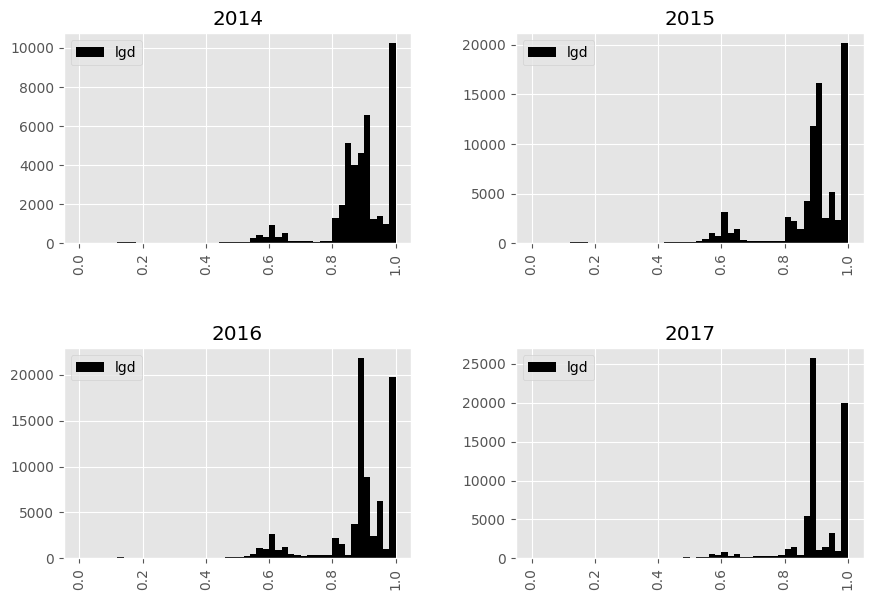

In [7]:
fig = plt.figure();
#plt.style.use('bmh')
plt.style.use('ggplot')
df.hist(column='lgd', by='year', grid=False, histtype='barstacked', bins=50, sharey=False, legend=True, color='black', range=[0,1], figsize = (10, 7))
plt.show()

Abaixo foi avaliado se a renda não verificada deveria ser excluída, conforme artigo `P2P`, porém nota-se que não há diferença no nível de LGD entre os tipos de verificação, o que não justifica a exclusão. Dessa forma todos os registros foram mantidos.

In [8]:
del total
df.groupby(['verification_status'], as_index=False).agg({'id':'count', 'lgd': np.mean})

,verification_status,id,lgd
0,Not Verified,59263,0.889056
1,Source Verified,114942,0.887496
2,Verified,92310,0.884397



## 1.2 Realizando do tratamentos iniciais nas informações

Nesta etapa, alguns tratamentos gerais e exclusões são feitos antes de iniciar os diferentes testes. Em resumo, das 143 variáveis são excluídas 53, conforme tabela abaixo que identifica as exclusões e motivos:

variável | Motivo da exclusão | Detalhe
-|-|-
id | identificação da operação | id
funded_amnt | idêntica à variável "loan_amnt" |
emp_title | muito granular |
issue_d | construída a variável year |
loan_status | todos os valores iguais | charge-off
pymnt_plan | todos os valores iguais | letra n
url | identificação da operação | endereço web
title | muito granular |
zip_code | muito granular |
addr_state | muito granular |
initial_list_status | caracteriza o investidor e não o tomador |
out_prncp | todos os valores iguais | 0
out_prncp_inv | todos os valores iguais | 0
total_pymnt_inv | caracteriza o investidor e não o tomador |
recoveries | variável futura, pós lgd |
collection_recovery_fee | variável futura, pós lgd |
last_pymnt_d | variável futura, pós lgd |
last_pymnt_amnt | variável futura, pós lgd |
next_pymnt_d | todos os valores iguais | 0
last_credit_pull_d | variável futura, pós lgd |
policy_code | todos os valores iguais | 1
annual_inc_joint | baixo preenchimento | 2,7%
dti_joint | baixo preenchimento | 2,7%
verification_status_joint | baixo preenchimento | 2,7%
num_tl_30dpd | baixo preenchimento | 0,37%
revol_bal_joint | baixo preenchimento | 2,2%
sec_app_fico_range_low | baixo preenchimento | 2,2%
sec_app_fico_range_high | baixo preenchimento | 2,2%
sec_app_earliest_cr_line | baixo preenchimento | 2,2%
sec_app_inq_last_6mths | baixo preenchimento | 2,2%
sec_app_mort_acc | baixo preenchimento | 2,2%
sec_app_open_acc | baixo preenchimento | 2,2%
sec_app_revol_util | baixo preenchimento | 2,2%
sec_app_open_act_il | baixo preenchimento | 2,2%
sec_app_num_rev_accts | baixo preenchimento | 2,2%
sec_app_chargeoff_within_12_mths | baixo preenchimento | 2,2%
sec_app_collections_12_mths_ex_med | baixo preenchimento | 2,2%
hardship_flag | baixo preenchimento | 0,003%
hardship_type | baixo preenchimento | 2,4%
hardship_reason | baixo preenchimento | 2,4%
hardship_status | baixo preenchimento | 2,4%
deferral_term | baixo preenchimento | 2,4%
hardship_amount | baixo preenchimento | 2,4%
hardship_start_date | baixo preenchimento | 2,4%
hardship_end_date | baixo preenchimento | 2,4%
payment_plan_start_date | baixo preenchimento | 2,4%
hardship_length | baixo preenchimento | 2,4%
hardship_dpd | baixo preenchimento | 2,4%
hardship_loan_status | baixo preenchimento | 2,4%
orig_projected_additional_accrued_interest | baixo preenchimento | 2,4%
hardship_payoff_balance_amount | baixo preenchimento | 2,4%
hardship_last_payment_amount | baixo preenchimento | 2,4%
debt_settlement_flag | variável futura, pós lgd |


Outras 5 variáveis auxiliares são criadas, que indicam se o preenchimento de outra é nulo e foi transformado em zero. São elas:


variável original | Variável indicativa criada  
-|-
mths_since_last_delinq | mths_since_last_delinq_null
mths_since_last_record |mths_since_last_record_null
mths_since_last_major_derog | mths_since_last_major_derog_null
mths_since_recent_bc_dlq | mths_since_recent_bc_dlq_null
mths_since_recent_revol_delinq | mths_since_recent_revol_delinq_null

Finalmente são criadas Dummies para as variáveis listadas abaixo:

*   grade
*   home_ownership
*   purpose

O que deixa a base final com **112** variáveis, incluindo o ano, que será usado apenas para controle das amostras posteriormente.


In [9]:
# transformando o plano de pagamento em numérico e depois em dummy = 1 (60 meses)
df['term_c'] = np.where(pd.to_numeric(df['term'].str.replace(' months', ''))==60, 1, 0)

# transformando a taxa de juros em numérico
df['int_rate_n'] = pd.to_numeric(df['int_rate'].str.replace('%', ''))

# Tratando a variável subgrade, de categorias para contínua
a = {'A1':1,'A2':2,'A3':3,'A4':4,'A5':5,'B1':6,'B2':7,'B3':8,'B4':9,'B5':10,'C1':11,'C2':12,'C3':13,'C4':14,'C5':15,\
     'D1':16,'D2':17,'D3':18,'D4':19,'D5':20,'E1':21,'E2':22,'E3':23,'E4':24,'E5':25,\
     'F1':26,'F2':27,'F3':28,'F4':29,'F5':30,'G1':31,'G2':32,'G3':33,'G4':34,'G5':35}
df['sub_grade_n'] = df['sub_grade'].map(a)

# Tratando o texto da variável tempo de emprego
df['emp_length_n'] = df['emp_length'].str.replace('\+ years', '') #subst palavra por vazio
df['emp_length_n'] = df['emp_length_n'].str.replace('< 1 year', str(0)) #subst <1 ano por 0 (zero)
df['emp_length_n'] = df['emp_length_n'].str.replace('n/a',  str(0)) #subst S/I por 0 (zero)
df['emp_length_n'] = df['emp_length_n'].str.replace(' years', '') #subst palavra por vazio
df['emp_length_n'] = df['emp_length_n'].str.replace(' year', '') #subst palavra por vazio
df['emp_length_n'] = pd.to_numeric(df['emp_length_n']) #Transforma em numérico
df['emp_length_n'] = np.where(df['emp_length_n']==0, 0.5, df['emp_length_n']) # Transforma 0 anos em 0.5
df['emp_length_n'].fillna(0, inplace=True) # nos casos sem informação assume-se 0 (pior condição)

# Categorizada em verificada e não verificada
b = {'Not Verified':0,'Source Verified':1,'Verified':1}
df['verification_c'] = df['verification_status'].map(b)

# Tratando o dti - endividamento
df['dti'].fillna(0, inplace=True) #85 nulas

# Data da primeira linha de crédito, transformado em tempo de relacionamento no mercado em anos base 2017
df['earliest_cr_line_n'] = 2017 - pd.DatetimeIndex(df['earliest_cr_line']).year

# Preenchendo com 0 os valores nulos e criando indicador de não ocorrencia
df['mths_since_last_delinq_null'] = np.where(df['mths_since_last_delinq'].isnull(),1,0)
df['mths_since_last_delinq'].fillna(0, inplace=True) #125323 nulas
df['mths_since_last_record_null'] = np.where(df['mths_since_last_record'].isnull(),1,0)
df['mths_since_last_record'].fillna(0, inplace=True) #210424 nulas
df['mths_since_last_major_derog_null'] = np.where(df['mths_since_last_major_derog'].isnull(),1,0)
df['mths_since_last_major_derog'].fillna(0, inplace=True) #183776 nulas

# Preenchendo com 0 os valores nulos e transforma a info em número ao invés de texto
df['revol_util_n'] = pd.to_numeric(np.where(df['revol_util'].isnull(),0,df['revol_util'].str.replace('%', '')))

# Categorizando variáveis para empréstimos conjuntos e preenchendo com 0 os valores nulos
c = {'Joint App':0,'Individual':1}
df['application_type_c'] = df['application_type'].map(c)

# Preenchendo nulos com zeros
df['open_acc_6m'].fillna(0, inplace=True) #117319 nulas
df['open_act_il'].fillna(0, inplace=True) #117319 nulas
df['open_il_12m'].fillna(0, inplace=True) #117319 nulas
df['open_il_24m'].fillna(0, inplace=True) #117319 nulas
df['mths_since_rcnt_il'].fillna(0, inplace=True) #121784 nulas
df['total_bal_il'].fillna(0, inplace=True) #117319 nulas
df['il_util'].fillna(0, inplace=True) #136010 nulas
df['open_rv_12m'].fillna(0, inplace=True) #117319 nulas
df['open_rv_24m'].fillna(0, inplace=True) #117319 nulas
df['max_bal_bc'].fillna(0, inplace=True) #117319 nulas
df['all_util'].fillna(0, inplace=True) #117319 nulas
df['inq_fi'].fillna(0, inplace=True) #117319 nulas
df['total_cu_tl'].fillna(0, inplace=True) #117319 nulas
df['inq_last_12m'].fillna(0, inplace=True) #117319 nulas
df['avg_cur_bal'].fillna(0, inplace=True) #5 nulas
df['bc_open_to_buy'].fillna(0, inplace=True) #2929 nulas
df['bc_util'].fillna(0, inplace=True) #3090 nulas
df['mo_sin_old_il_acct'].fillna(0, inplace=True) #7939 nulas
df['num_tl_120dpd_2m'].fillna(0, inplace=True) #16062 nulas
df['percent_bc_gt_75'].fillna(0, inplace=True) #3009 nulas

# Categorizando variáveis atrasos em contas internas e preenchendo com 0 os valores nulos
df['mths_since_recent_bc'].fillna(0, inplace=True) #2764 nulas
df['mths_since_recent_bc_dlq'].fillna(0, inplace=True) #196726 nulas
df['mths_since_recent_bc_dlq_null'] = np.where(df['mths_since_recent_bc_dlq'].isnull(),1,0)
df['mths_since_recent_inq'].fillna(0, inplace=True) #19513 nulas
df['mths_since_recent_revol_delinq'].fillna(0, inplace=True) #196726 nulas
df['mths_since_recent_revol_delinq_null'] = np.where(df['mths_since_recent_revol_delinq'].isnull(),1,0)

df = df[['lgd','year','loan_amnt','funded_amnt_inv','term_c','int_rate_n','installment','grade','sub_grade_n',\
         'emp_length_n','home_ownership','annual_inc','verification_c','purpose','dti','delinq_2yrs',\
         'earliest_cr_line_n','fico_range_low','fico_range_high','inq_last_6mths','mths_since_last_delinq',\
         'mths_since_last_delinq_null','mths_since_last_record','mths_since_last_record_null','open_acc','pub_rec','revol_bal',\
         'revol_util_n','total_acc','total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee',\
         'last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','mths_since_last_major_derog',\
         'mths_since_last_major_derog_null','application_type_c','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m',\
         'open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',\
         'open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m',\
         'acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths','delinq_amnt',\
         'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',\
         'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_bc_dlq_null',\
         'mths_since_recent_inq','mths_since_recent_revol_delinq','mths_since_recent_revol_delinq_null',\
         'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',\
         'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',\
         'num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies',\
         'tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit']]

# Cria as dummies e concatena na tabela final
dummies = [pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ':'),
           pd.get_dummies(df['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
           pd.get_dummies(df['purpose'], prefix = 'purpose', prefix_sep = ':')]

dummies = pd.concat(dummies, axis = 1)
df1 = pd.concat([df, dummies], axis = 1)
df1 = df1.drop(['grade','grade:G','home_ownership','home_ownership:RENT','purpose','purpose:small_business'], axis = 1)
del df, dummies

print('df1 (linhas, colunas) =', df1.shape) # (266515, 112)

df1 (linhas, colunas) = (266515, 112)



## 1.3 Carregando programas auxiliares

Aqui são pré-processadas algumas funções que auxiliarão as análises mais à frente.

A função abaixo calcula as estatísticas apresentadas abaixo:



Estatística | Detalhamento
-|-
**mae** | *Mean Absolut Error*. Mensura a média da diferença absoluta entre os valores observados e estimados (erros).
**rmse** | *Root Mean Squared Error*. Refere-se à média da raiz quadrada entre os valores observados e estimados (erros).
**R2** | *Coeficiente de Determinação* refere-se à proporção da variância que pode ser explicada pelo modelo.
**qtd** | Número de observações relativas aos cálculos das estatísticas.
**r** | *Correlação de Pearson* mede o grau de relação linear entre os valores observados e estimados.
**rho** | *Correlação de Spearman* mede o grau de relação entre os valores observados e estimados usando uma função monotônica.
**tau** | *Correlação de Kendall* mede o grau de correspondência entre os valores observados e estimados.

In [10]:
# Função usado para avaliar a performance nas diferentes amostras
def reg_metrics(y, y_pred, X):
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import scipy.stats

    mae = mean_absolute_error(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred)) #penaliza mais a existência de outliers
    r2 = r2_score(y,y_pred)
    n = y_pred.shape[0]

    df_y = pd.DataFrame(y, columns = ['y'])
    r = scipy.stats.pearsonr(df_y['y'].tolist(),y_pred.tolist())[0] # Pearson's r
    rho = scipy.stats.spearmanr(df_y['y'].tolist(),y_pred.tolist()).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(df_y['y'].tolist(),y_pred.tolist()).correlation  # Kendall's tau

    print('mae:',round(mae,7),'rmse:',round(rmse,7),'R2:',round(r2,7),\
          'Qtd:',n, 'r:', round(r,7), 'rho:', round(rho,7), 'tau:', round(tau,7))

In [11]:
# Função usado para avaliar a performance nas diferentes amostras e retorna um objeto
def reg_metrics_ret(amostra, y, y_pred, X):
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import scipy.stats

    mae = mean_absolute_error(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred)) #penaliza mais a existência de outliers
    r2 = r2_score(y,y_pred)
    n = y_pred.shape[0]

    df_y = pd.DataFrame(y, columns = ['y'])
    r = scipy.stats.pearsonr(df_y['y'].tolist(),y_pred.tolist())[0] # Pearson's r
    rho = scipy.stats.spearmanr(df_y['y'].tolist(),y_pred.tolist()).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(df_y['y'].tolist(),y_pred.tolist()).correlation  # Kendall's tau

    dados = [[amostra, n, round(mae,7),round(rmse,7), round(r2,7), round(r,7), round(rho,7), round(tau,7)]]
    df_out = pd.DataFrame(dados, columns=['amostra','qtd', 'mae', 'rmse', 'r2', 'r', 'rho', 'tau'])

    return df_out

Função para avaliar a multicolinearidade e influência de outliers, principalmente nas regressões lineares.

In [12]:
# Informa a matriz de entrada em "X" e a quantidade de variáveis a serem listadas em "Z"
def vif(X,Z):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i).round(decimals=1)
                              for i in range(len(X.columns))]
    vif_data = vif_data.sort_values(by=['VIF'], ascending=False).head(Z)
    print(vif_data)

# 2 . Desenvolvimento ML usando AutoSklearn

Existem várias alternativas de Auto-ML no Python. Optou-se aqui pelo uso autosklearn, principalmente pela baixa necessidade de parametrização pelo
usuário e pela sua melhor performance comparativa em termos de acurácia e tempo de
processamento. Para avaliar a performance do algoritmo promovemos as seguintes
variações no processamento.

*   **Tamanho da amostra:** Aqui foram 3 variações testadas, 100%, 10% e 0,5%, o que gerou amostras com 97.147, 9.714 e 485 observações respectivamente. O tamanho é definido no bloco a seguir, bastando comentar/descomentar o trecho logo após a importação da biblioteca.

*   **Tempo:** O algoritmo foi testado em 1h (7mins máximo por modelo) e 3h (20mins máximos por modelo). A parametrização dessa etapa é feita diretamente na função `automl` do 2º bloco à seguir e é definida em segundos.

Para evitar falha por falta de memória RAM, o ideal é que os blocos dessa etapa sejam processados individualmente. Nos blocos seguintes são processadas as saídas de cada modelo.

**Como a ideia foi intervir o mínimo possível na parametrização do modelo, o resultado pode ser diferente considerando os parâmetros iniciais mínimos informados, o que limita a replicabilidade do estudo.**



In [13]:
def auto_ml(df, perc, time_model, time_task):

  # tempos em segundos
  # time_task = 3 hs = 10800s / 1h = 3600s -> tempo limite para o processamento geral
  # time_model = 20 min = 900s / 7 min = 420s -> tempo limite para cada modelo

  from sklearn.model_selection import train_test_split
  import autosklearn.regression
  import shap

  df1 = df

  if perc >= 100:
    df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
  else:
    df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
    df_des = df_des.sample(frac = perc/100, replace = False, random_state = 2)

  y = df_des.pop('lgd').to_numpy() #aqui eu tiro o LGD da base das variáveis explicativas
  X = df_des.to_numpy()

  # Determinação da amostra de treinamento e
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test

  # Separa as amostras de validação out-of-time
  X_2016 = df1[df1['year']==2016].drop(columns=['year']) #(78998, 111)
  X_2017 = df1[df1['year']==2017].drop(columns=['year']) #(66083, 111)
  y_2016 = X_2016.pop('lgd').to_numpy()
  X_2016 = X_2016.to_numpy()
  y_2017 = X_2017.pop('lgd').to_numpy()
  X_2017 = X_2017.to_numpy()

  automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=time_task,
    per_run_time_limit=time_model,
    ensemble_nbest = 5,
    seed = 120,
    metric = autosklearn.metrics.r2, #r2, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_squared_log_error, median_absolute_error
    n_jobs=-1,  # predict() is not affected by n_jobs
  )
  automl.fit(X_train, y_train, feat_type=['Numerical']*110)

  # Retorna o valor previsto nas diferentes amostras
  y_pred_train = automl.predict(X_train)
  y_pred_test = automl.predict(X_test)
  y_pred_2016 = automl.predict(X_2016)
  y_pred_2017 = automl.predict(X_2017)

  # Gera as métricas de qualidade da Base
  resultado = reg_metrics_ret('treino',y_train, y_pred_train, X_train)
  resultado = resultado.append(reg_metrics_ret('teste', y_test, y_pred_test, X_test))
  resultado = resultado.append(reg_metrics_ret('teste_2016', y_2016, y_pred_2016, X_2016))
  resultado = resultado.append(reg_metrics_ret('teste_2017', y_2017, y_pred_2017, X_2017))

  X_train_shap = shap.sample(X_train, 500, random_state = 2) # Automaticamente limitado ao tamanho da amostra qdo < 500
  explainer = shap.KernelExplainer(automl.predict, X_train_shap, link="identity") # comando utilizado para o modelo de ML
  shap_values = explainer.shap_values(X_train_shap, feature_perturbation="correlation_dependent", nsamples=5)

  shap_df = pd.DataFrame(shap_values, columns=df_des.columns.to_list())
  vals = np.abs(shap_df.values).mean(0)*100
  shap_importance = pd.DataFrame(list(zip(df_des.columns.to_list(), vals)), columns=['col_name', 'feature_importance_vals'])
  shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
  shap_data = shap_importance.head(15)

  return resultado, shap_data


## 2.1 Processamento de 1 hora

Abaixo o processamento do código e geração de output para 10 simulações que são processadas individualmente. Basta alterar os parâmetros de tempo de processamento e tamanho da amostra nas linhas 4 e 5:

*   0,5% da população
*   10% da população
*   100% da população

Os dados são salvos em uma planilha em excel para geração de estatísticas e posterior consolidação.


In [14]:
import time
inicio = time.time()

res, shap = auto_ml(df1, 100, 420, 3600) # <------
#res, shap = auto_ml(df1, 100, 900, 10800) # <------

writer  = pd.ExcelWriter('lgd_100perc_1h_9.xlsx', engine='xlsxwriter') #incluir um sufixo com o número da simulação
#writer  = pd.ExcelWriter('lgd_100perc_3h_9.xlsx', engine='xlsxwriter')
res.to_excel(writer, sheet_name='result')
shap.to_excel(writer, sheet_name='shap')

fim = time.time()
tempo=pd.DataFrame([(fim - inicio)/3600])
tempo.to_excel(writer, sheet_name='tempo')
writer.save()

print((fim - inicio)/3600)
writer.save()

[WARNING] [2024-02-29 18:42:52,421:shap] Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

1.493804016775555


# 3 . Método Tradicional

Nessa etapa, são desenvolvidos os modelos de LGD chamados tradicionais. Como a distribuição não é Bi-Modal (o que ocorre com o LGD de algumas carteiras de crédito), optou-se por utilizar apenas os métodos de Árvore de Decisão e Regressão Linear.

## 3.1 Árvore de Decisão

Nesta etapa são apresentados os resultados para a **Árvore de Decisão**. Aqui são criadas variáveis ligadas ao LGD não presentes na base original. São elas:

variável criada | Explicação  
-|-
ead | valor da dívida no momento do default
ead_ind | ead / renda do devedor
ead_loan | ead / valor original tomado

Além disso, algumas observações com valores extremos para as variáveis `dti` e `ead_inc` são censuradas. Finalmente as variáveis `ead` e `loan_amnt` são transformadas em milhares, para facilitar a leitura dos resultados na etapa posterior de regressão linear.

Dessa forma, a base passa de **112** para **115** variáveis.

A metodologia utilizada é a de maximização do R2 (existem várias outras metodologias disponíveis, conforme link: [Métodos](https://https://scikit-learn.org/stable/modules/model_evaluation.html) ).


In [ ]:
# Valor do empréstimo em milhares de dólares e criação da variável EAD e EAD/Renda
df1['ead'] = (df1['loan_amnt']-df1['total_rec_prncp'])/1000
df1['ead_inc'] = (df1['loan_amnt']-df1['total_rec_prncp'])/df1['annual_inc']
df1['ead_inc'] = np.where(df1['ead_inc'] > 30, 30, df1['ead_inc']) # 89 censurados
df1['ead_loan'] = (df1['loan_amnt']-df1['total_rec_prncp'])/df1['loan_amnt']
df1['loan_amnt'] = df1['loan_amnt']/1000
df1['dti'] = np.where(df1['dti']>200, 200, df1['dti']) #56 censurados

print('df1 (linhas, colunas) =',df1.shape)

df1 (linhas, colunas) = (266515, 115)


### 3.1.1 Processamento do bloco

Na função abaixo `tree_lgd`, pode ser simulado qualquer percentual de amostra de desenvolvimento entre 1 e 100%.

In [ ]:
def tree_lgd(df,perc):
  from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
  from sklearn.model_selection import train_test_split # Import train_test_split function

  df1 = df

  if perc >= 100:
    df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
  else:
    df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
    df_des = df_des.sample(frac = perc/100, replace = False, random_state = 2) #10%

  # Separa as amostras de validação out-of-time
  df_2016 = df1[df1['year']==2016].drop(columns=['year'])
  df_2017 = df1[df1['year']==2017].drop(columns=['year'])

  feature_cols = ['loan_amnt','term_c','int_rate_n','ead','ead_inc','ead_loan','emp_length_n',\
                  'annual_inc','dti','delinq_2yrs','mths_since_last_delinq','mths_since_last_delinq_null',\
                  'pub_rec','inq_last_12m','fico_range_high', 'fico_range_low', 'grade:A','grade:B','grade:C','grade:D',\
                  'grade:E','grade:F','home_ownership:ANY','home_ownership:MORTGAGE','home_ownership:OWN',\
                  'purpose:car','purpose:credit_card','purpose:debt_consolidation','purpose:home_improvement',\
                  'purpose:house','purpose:major_purchase','purpose:medical','purpose:moving',\
                  'purpose:other','purpose:renewable_energy','purpose:vacation']

  X = df_des[feature_cols].to_numpy()
  y = df_des[['lgd']].to_numpy() # Target variable
  X_2016 = df_2016[feature_cols].to_numpy()
  y_2016 = df_2016[['lgd']].to_numpy()
  X_2017 = df_2017[feature_cols].to_numpy()
  y_2017 = df_2017[['lgd']].to_numpy()

  # Determinação da amostra de treinamento e Teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) # 80% training and 20% test
  # Create Decision Tree Regressor object (resposta contínua)
  clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.025, min_impurity_decrease=0.000001)
  # Train Decision Tree Classifer
  clf = clf.fit(X_train,y_train)
  # Predict the response for test dataset
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
  y_pred_2016 = clf.predict(X_2016)
  y_pred_2017 = clf.predict(X_2017)

  # Gera o gráfico da estrutura da árvore
  from sklearn.tree import export_graphviz
  from io import StringIO
  from IPython.display import Image
  import pydotplus
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,
                  filled=True, rounded=True,
                  special_characters=False,leaves_parallel=False,proportion=False,rotate=False, node_ids=True, feature_names = feature_cols),
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('lgd.png')

  from matplotlib import pyplot as plt
  from matplotlib import image as mpimg
  fig, ax = plt.subplots(figsize=(50, 20))
  image = mpimg.imread("lgd.png")
  plt.imshow(image)
  plt.show()

  reg_metrics(y_train, y_pred_train, X_train)
  reg_metrics(y_test, y_pred_test, X_test)
  reg_metrics(y_2016, y_pred_2016, X_2016)
  reg_metrics(y_2017, y_pred_2017, X_2017)

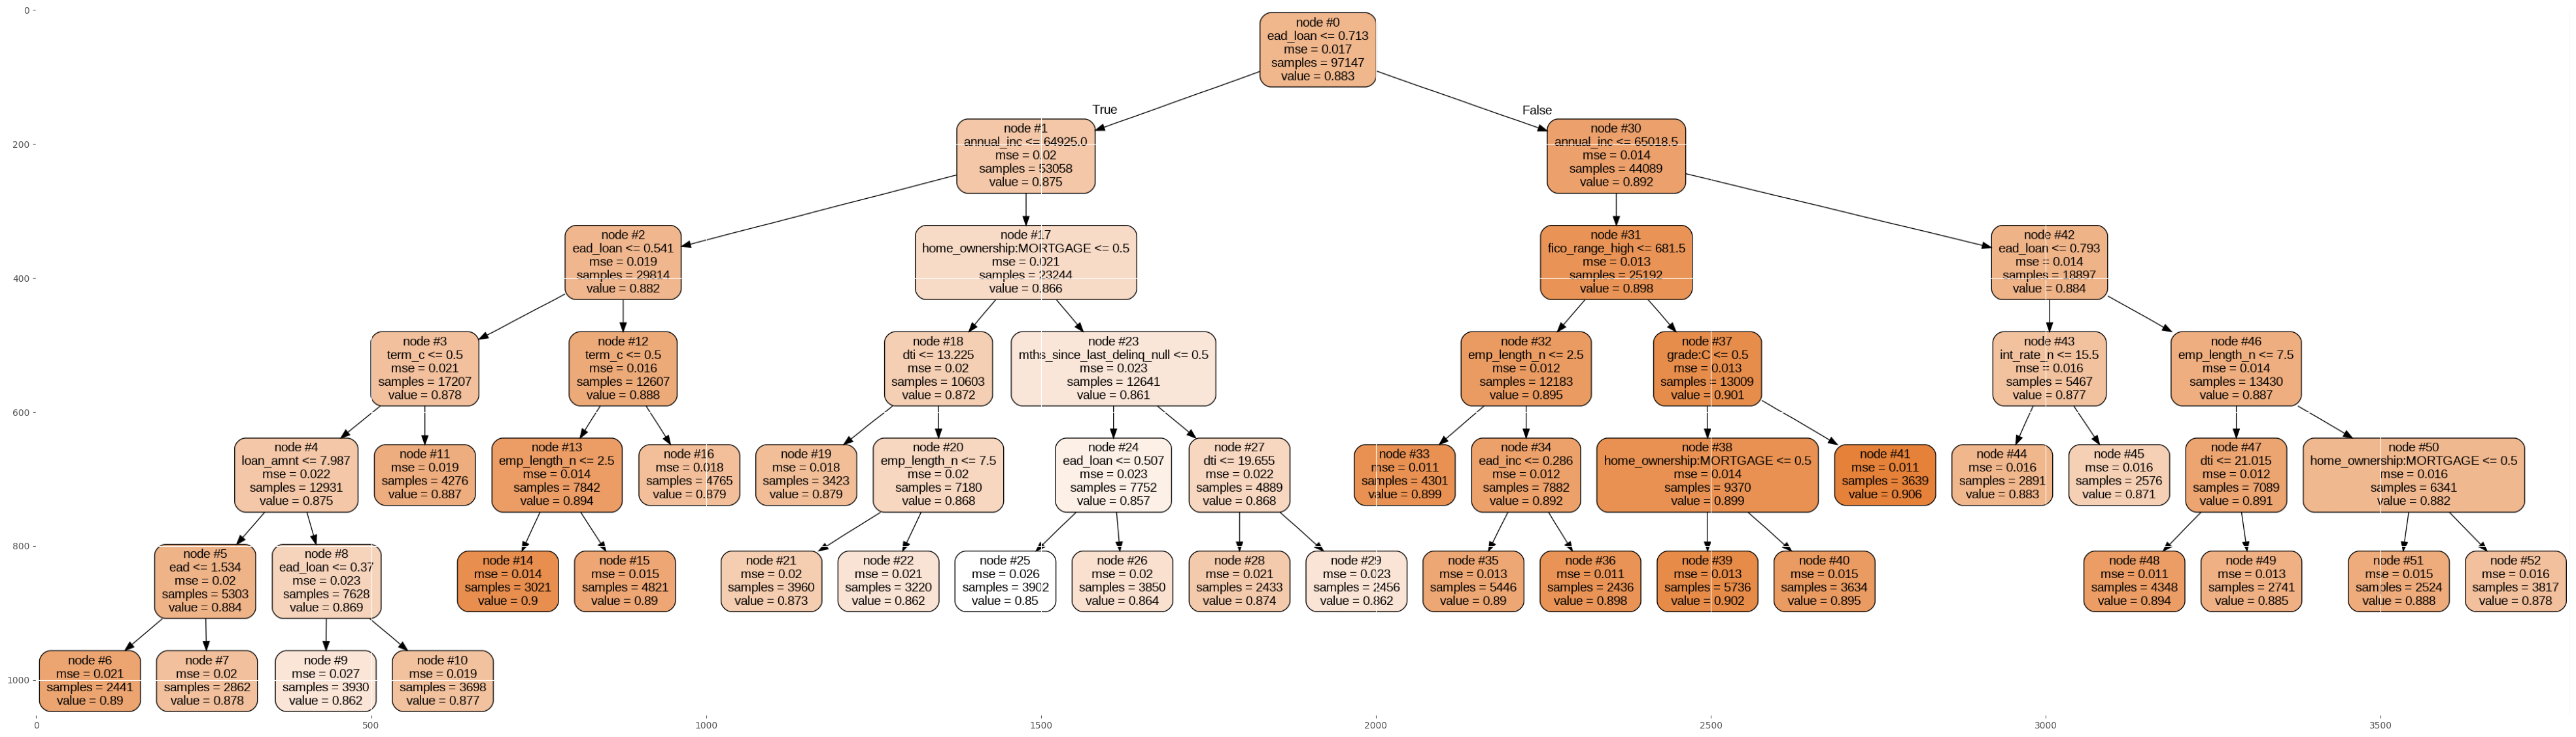

mae: 0.087271 rmse: 0.130107 R2: 0.0118849 Qtd: 97147 r: 0.1090177 rho: 0.0676501 tau: 0.0470723
mae: 0.0874508 rmse: 0.1313334 R2: 0.0105056 Qtd: 24287 r: 0.1026432 rho: 0.0656755 tau: 0.045426
mae: 0.0845684 rmse: 0.129609 R2: 0.0014819 Qtd: 78998 r: 0.0624921 rho: 0.0854084 tau: 0.0599967
mae: 0.0703145 rmse: 0.109679 R2: -0.0505883 Qtd: 66083 r: -0.0594192 rho: -0.0624755 tau: -0.0439017


In [ ]:
# processamento para 100% da base
tree_lgd(df1,100)

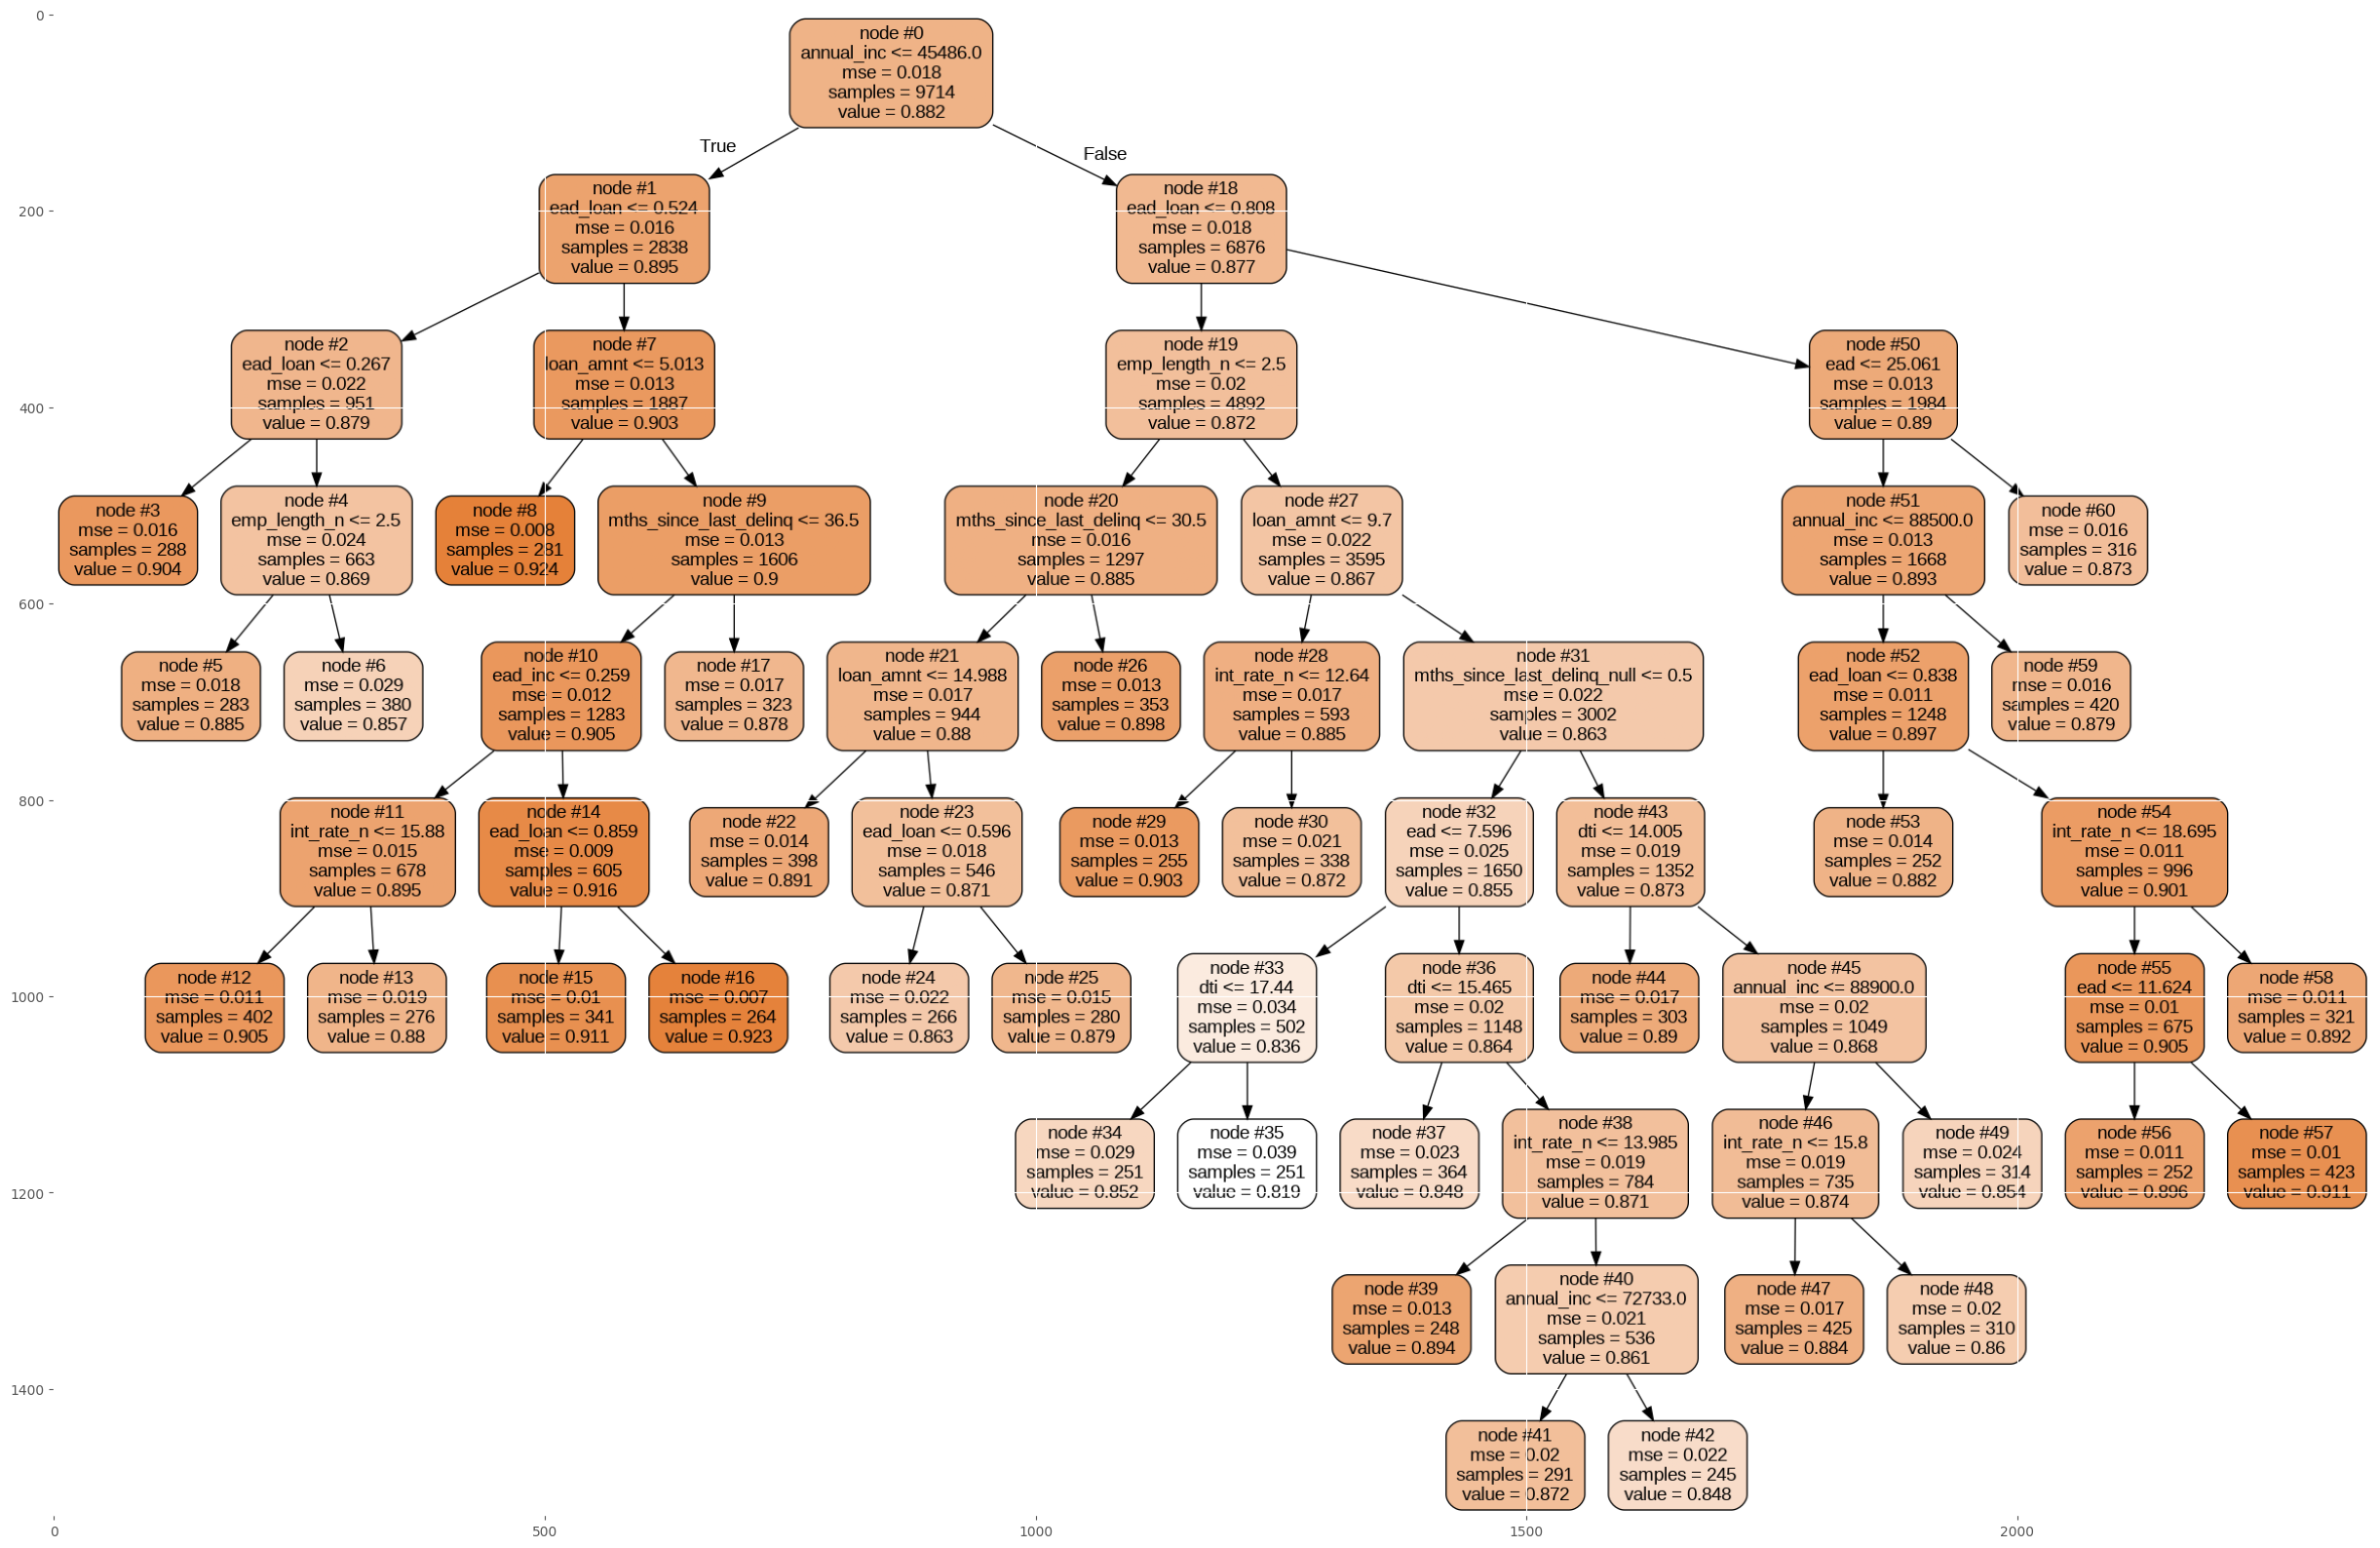

mae: 0.0881421 rmse: 0.1306064 R2: 0.0295571 Qtd: 9714 r: 0.1719218 rho: 0.1392377 tau: 0.0970646
mae: 0.0927639 rmse: 0.1397306 R2: -0.0092568 Qtd: 2429 r: 0.0561838 rho: 0.0348991 tau: 0.0244893
mae: 0.0867148 rmse: 0.1307871 R2: -0.0167532 Qtd: 78998 r: 0.0379152 rho: 0.0720445 tau: 0.0499968
mae: 0.0726523 rmse: 0.1108085 R2: -0.0723387 Qtd: 66083 r: -0.0271349 rho: 0.0048079 tau: 0.0036166


In [ ]:
# processamento para 10% da base
tree_lgd(df1,10)

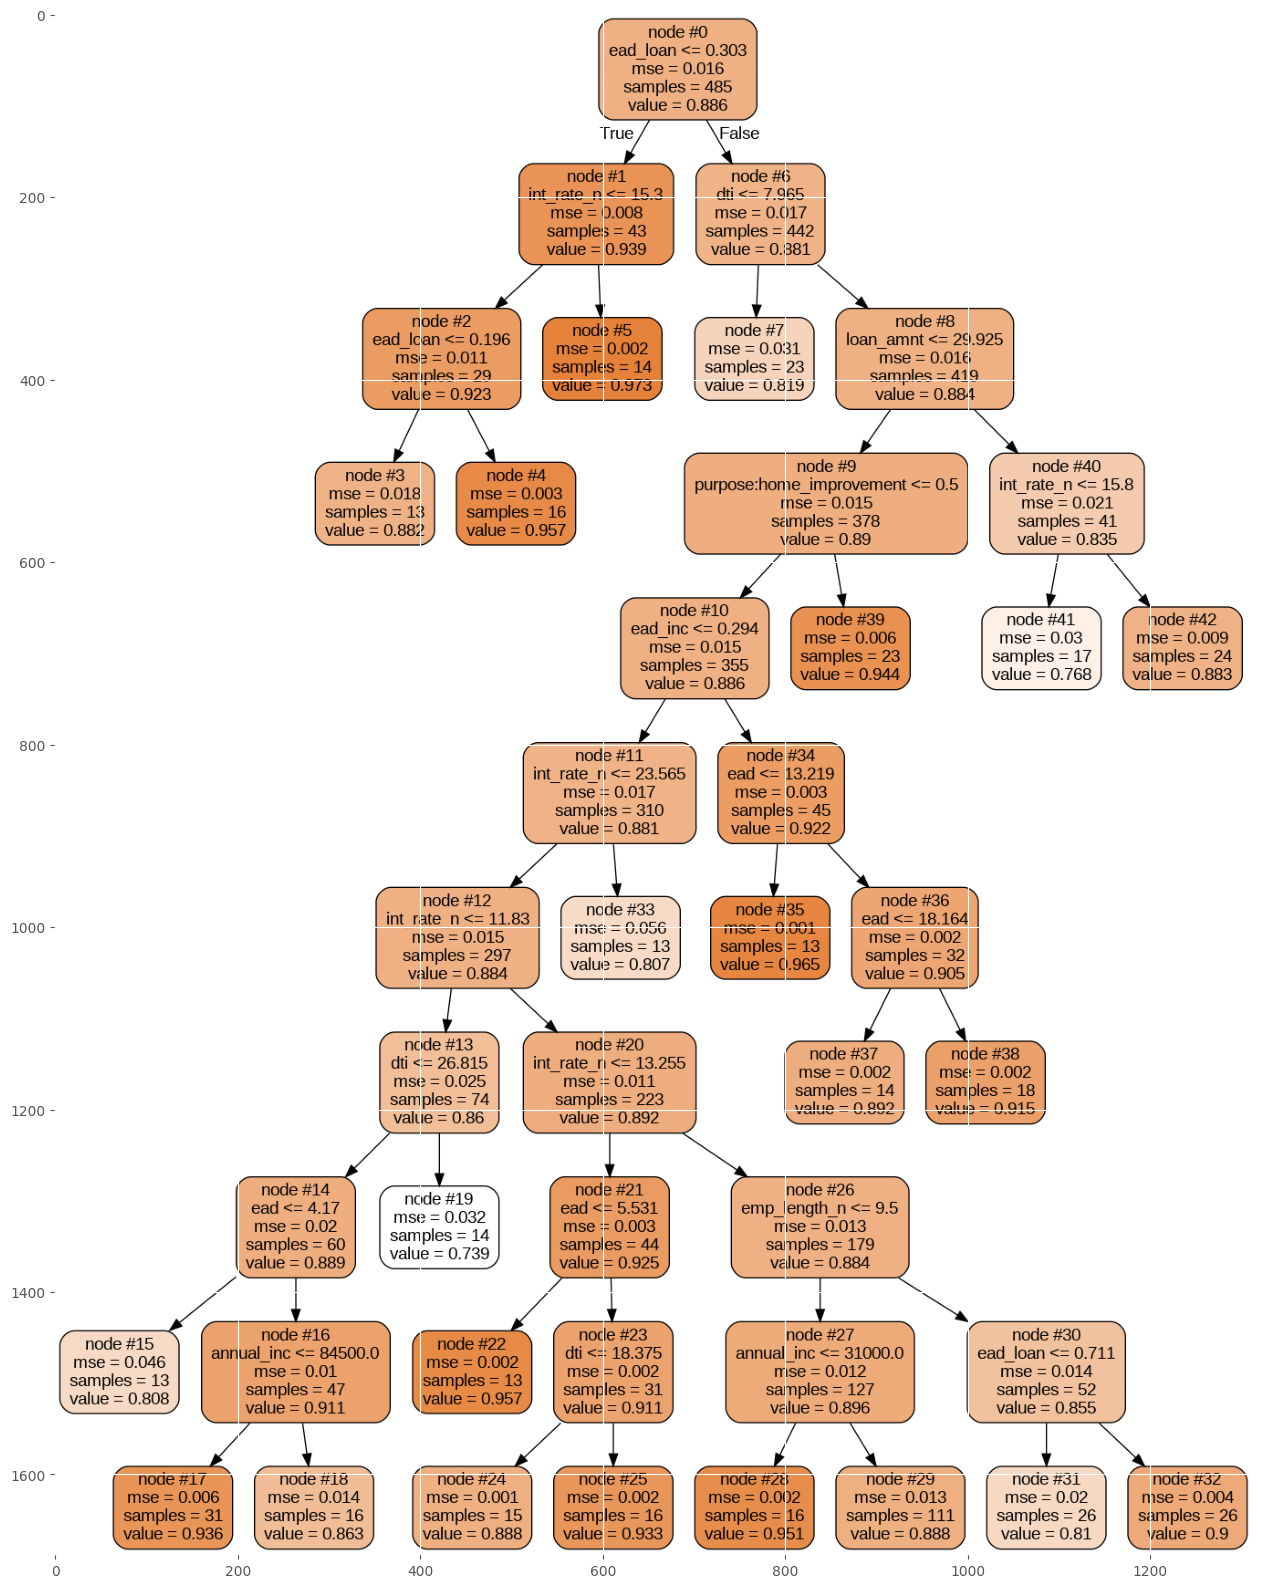

mae: 0.0790669 rmse: 0.1141212 R2: 0.2000702 Qtd: 485 r: 0.4472921 rho: 0.4023625 tau: 0.2927594
mae: 0.1021057 rmse: 0.1392546 R2: -0.1880086 Qtd: 122 r: 0.0481428 rho: -0.0251021 tau: -0.0121686
mae: 0.0998326 rmse: 0.1417133 R2: -0.1937316 Qtd: 78998 r: 0.0118184 rho: 0.0261074 tau: 0.0190183
mae: 0.0882998 rmse: 0.1238255 R2: -0.3390772 Qtd: 66083 r: 0.0125498 rho: 0.021629 tau: 0.0168258


In [ ]:
# processamento para 0,5% da base
tree_lgd(df1,0.5)

## 3.2 Regressão Linear

Nesta etapa são apresentados os resultados para a **Regressão Linear.** Aqui são utilizadas as mesmas variáveis da etapa anterior, no entanto 4 delas são transformadas em ln, minimizando o efeito de valores extremos e assimetria da distribuição. São elas:

1. `loan_amnt`
2. `int_rate_n`
3. `ead`
4. `annual_inc`

No caso da variável `annual_inc`, ela também foi censurada em valores extremos, mas isso impactou apenas **127** observações.

Como não há criação ou exclusão de qualquer variável, a tabela mantém a mesma estrutura. O trecho a seguir deve ser processado uma única vez. Na sequencia o modelo é repetido para diferentes amostras.

In [ ]:
# Trata algumas variáveis contínuas com domínio fora de 0-1
df1['loan_amnt'] = np.log(df1['loan_amnt'])
df1['int_rate_n'] = np.log(df1['int_rate_n'])
df1['ead'] = np.log(df1['ead'])

# Dividido por 1000, para deixar a renda em milhares de dólares anuais, censurando
df1['annual_inc'] = np.where(df1['annual_inc']<100, 100, df1['annual_inc']) #87 casos <$100
df1['annual_inc'] = np.where(df1['annual_inc']>1000000, 1000000, df1['annual_inc']) #40 casos >$1M
df1['annual_inc'] = df1['annual_inc']/1000
df1['annual_inc'] = np.log(df1['annual_inc'])

#df1.shape (266515, 115)

### 3.2.1 Processamento recursivo do bloco

A analise aqui foi feita em 2 etapas:

1. O modelo inteiro é processado, e são excluídas individualmente as variáveis com p-valor > 0.06.
2. o conjunto final é avalido o `VIF` e variáveis muito correlacionadas são retiradas, partindo daquelas com maior p-valor e cujo VIF seja > 20.

Não foram excluídas as variáveis com sinal diferente do esperado. Elas serão discutidas no resultado.

Foram mantidos apenas os resultados finais das 2 amostras.

In [ ]:
def reg_lgd(df,perc,feature_cols):
  import statsmodels.api as sm

  df1 = df

  if perc >= 100:
    df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
    des_train=df_des.sample(frac=0.8,random_state=2)
    des_test=df_des.drop(des_train.index)
  else:
    df_des = df1[df1.year.isin([2014,2015])].drop(columns=['year'])
    df_des = df_des.sample(frac=perc/100, replace = False, random_state = 2)
    des_train=df_des.sample(frac=0.8,random_state=2)
    des_test=df_des.drop(des_train.index)

  # Separa as amostras de validação out-of-time
  df_2016 = df1[df1['year']==2016].drop(columns=['year'])
  df_2017 = df1[df1['year']==2017].drop(columns=['year'])

  X_train = des_train[feature_cols]
  y_train = des_train[['lgd']]
  y_train.rename(columns = {'lgd':'y'}, inplace = True)
  X_test = des_test[feature_cols]
  y_test = des_test[['lgd']]
  y_test.rename(columns = {'lgd':'y'}, inplace = True)
  X_2016 = df_2016[feature_cols]
  y_2016 = df_2016[['lgd']]
  y_2016.rename(columns = {'lgd':'y'}, inplace = True)
  X_2017 = df_2017[feature_cols]
  y_2017 = df_2017[['lgd']]
  y_2017.rename(columns = {'lgd':'y'}, inplace = True)

  # Processamento geral para avaliar o primeiro processamento da base.
  results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
  print(results.summary())
  y_pred_train = results.predict(sm.add_constant(X_train))
  y_pred_test = results.predict(sm.add_constant(X_test))
  y_pred_2016 = results.predict(sm.add_constant(X_2016))
  y_pred_2017 = results.predict(sm.add_constant(X_2017))
  print(end='\n')
  reg_metrics(y_train, y_pred_train, X_train)
  reg_metrics(y_test, y_pred_test, X_test)
  reg_metrics(y_2016, y_pred_2016, X_2016)
  reg_metrics(y_2017, y_pred_2017, X_2017)
  print(end='\n')
  vif(X_train,5)

In [ ]:
# Resultado para 100%
reg_lgd(df1,100,['term_c','ead_loan','emp_length_n','dti','delinq_2yrs','mths_since_last_delinq_null','pub_rec','grade:B','grade:C','grade:D','home_ownership:MORTGAGE','home_ownership:OWN','purpose:debt_consolidation','purpose:house','purpose:other'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     52.60
Date:                Thu, 29 Feb 2024   Prob (F-statistic):          8.93e-158
Time:                        16:20:08   Log-Likelihood:                 60062.
No. Observations:               97147   AIC:                        -1.201e+05
Df Residuals:                   97131   BIC:                        -1.199e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
# Resultado para 10%
reg_lgd(df1,10,['emp_length_n','dti','mths_since_last_delinq_null','home_ownership:MORTGAGE','home_ownership:OWN','purpose:moving','ead','ead_inc','pub_rec'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     10.38
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           3.97e-16
Time:                        16:20:11   Log-Likelihood:                 5906.7
No. Observations:                9714   AIC:                        -1.179e+04
Df Residuals:                    9704   BIC:                        -1.172e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
# Resultado para 0,5%
reg_lgd(df1,0.5,['purpose:home_improvement','purpose:moving'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.925
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00287
Time:                        16:20:11   Log-Likelihood:                 322.33
No. Observations:                 486   AIC:                            -638.7
Df Residuals:                     483   BIC:                            -626.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# 4 . Informações complementares


## 4.1 Componentes avaliados no Auto-Sklearn

Para os interessados, os componentes do auto-sklearn são detalhados na página do projeto no respectivo GitHub.

[Componentes do Auto-sklearn](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components)

Na sequência eles são listados, apenas para conhecimento.

1.   Regression - 12 (decision tree e adaboost)
2.   Classification - 16
3.   Feature_preprocessing - 18 (pca, polinomial, select percentile)
4.   Data_preprocessing - 9 (categorical encoding, imputation, texto_encoding) mas são métodos que se complementam.





In [ ]:
from autosklearn.pipeline.components.classification import ClassifierChoice

for name in ClassifierChoice.get_components():
    print(name)

adaboost
bernoulli_nb
decision_tree
extra_trees
gaussian_nb
gradient_boosting
k_nearest_neighbors
lda
liblinear_svc
libsvm_svc
mlp
multinomial_nb
passive_aggressive
qda
random_forest
sgd


In [ ]:
from autosklearn.pipeline.components.feature_preprocessing import FeaturePreprocessorChoice

for name in FeaturePreprocessorChoice.get_components():
    print(name)

densifier
extra_trees_preproc_for_classification
extra_trees_preproc_for_regression
fast_ica
feature_agglomeration
kernel_pca
kitchen_sinks
liblinear_svc_preprocessor
no_preprocessing
nystroem_sampler
pca
polynomial
random_trees_embedding
select_percentile_classification
select_percentile_regression
select_rates_classification
select_rates_regression
truncatedSVD


In [ ]:
from autosklearn.pipeline.components.regression import RegressorChoice

for name in RegressorChoice.get_components():
    print(name)

adaboost
ard_regression
decision_tree
extra_trees
gaussian_process
gradient_boosting
k_nearest_neighbors
liblinear_svr
libsvm_svr
mlp
random_forest
sgd


In [ ]:
from autosklearn.pipeline.components.data_preprocessing import DataPreprocessorChoice

for name in DataPreprocessorChoice.get_components():
    print(name)

feature_type
